In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm.notebook import tqdm
import IPython.display as ipd
import os
import time

from siren import get_siren_model
from gabor_mfn import get_gabor_mfn_model
from audio_utils import (
    AudioSignalDataset, 
    train_inr_model, 
    evaluate_audio_model,
    evaluate_and_visualize,
    play_audio
)

from pytorch_dqnn import PyTorchDQNN
from pytorch_dqnn_utils import (
    DQNNAudioDataset,
    train_dqnn_model,
    evaluate_dqnn_model,
    evaluate_and_visualize_dqnn,
    plot_training_curve,
    get_dqnn_model
)

In [2]:
torch.manual_seed(1)
np.random.seed(1)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
audio_paths = [
    "clarinet_by_mozart.wav",
    "flute_by_bach.wav", 
    "piano_by_bach.wav"
]
output_paths = [
    "outputs_clarinet",
    "outputs_flute",
    "outputs_piano"
]

for path in output_paths:
    if not os.path.exists(path):
        os.makedirs(path)

test, sr = sf.read(audio_paths[2])
ipd.Audio(test, rate=sr)



Training SIREN model on piano_by_bach.wav
Audio loaded: 220500 samples, 5.00 seconds at 44100Hz
Original amplitude range: (-0.1114, 0.1176)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (220500 samples)
SIREN model parameters: 16,833
Starting training for 5000 epochs...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed. Final loss: 0.032510, Best loss: 0.031507
SIREN training completed in 12.19 seconds


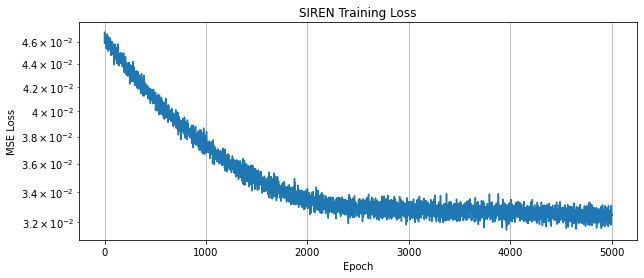


Evaluating SIREN model...
=== SIREN Evaluation (Denormalized)===
MSE: 0.000426
PSNR: 15.12 dB
Saved waveform plot to outputs_piano/siren_waveform.png



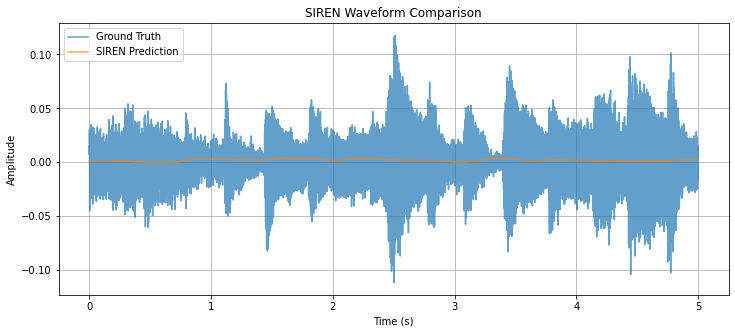

Ground Truth Audio (5.00 seconds):


SIREN Predicted Audio (5.00 seconds):


Saved predicted audio to outputs_piano/siren_audio.wav

Final SIREN metrics: MSE=0.000426, PSNR=15.12dB



In [6]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = output_paths[choice]

print("\n" + "="*50)
print(f"\nTraining SIREN model on {os.path.basename(audio_file)}")
print("="*50)

# Create dataset
dataset = AudioSignalDataset(
    audio_file,
    normalize_time=True,
    normalize_amplitude=True
)

# Configure SIREN model
hidden_size = 64
hidden_layers = 4
first_omega_0 = 30

siren_model = get_siren_model(
    hidden_size=hidden_size,
    hidden_layers=hidden_layers,
    first_omega_0=first_omega_0
)

# Print model details
num_params = sum(p.numel() for p in siren_model.parameters())
print(f"SIREN model parameters: {num_params:,}")

# Training hyperparameters
num_epochs = 5000
batch_size = 2**15
learning_rate = 1e-7

# Train SIREN model
start_time = time.time()

siren_model, siren_losses = train_inr_model(
    siren_model, 
    dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    lr=learning_rate, 
    device=device
)

training_time = time.time() - start_time
print(f"SIREN training completed in {training_time:.2f} seconds")

# Plot SIREN training curve
fig = plt.figure(figsize=(10, 4))
plt.plot(siren_losses)
plt.title("SIREN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.grid(True)
plt.show()
fig.savefig(f"{output_path}/siren_loss.png", dpi=300, bbox_inches='tight')

# Evaluate SIREN model
print("\nEvaluating SIREN model...")
predictions, ground_truth, mse, psnr = evaluate_and_visualize(
    siren_model, 
    dataset, 
    "SIREN",
    save_audio=f"{output_path}/siren_audio.wav",
    save_plot=f"{output_path}/siren_waveform.png"
)

print(f"\nFinal SIREN metrics: MSE={mse:.6f}, PSNR={psnr:.2f}dB\n")



Training Gabor MFN model on piano_by_bach.wav
Audio loaded: 220500 samples, 5.00 seconds at 44100Hz
Original amplitude range: (-0.1114, 0.1176)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (220500 samples)
Gabor MFN model parameters: 9,281
Starting training for 2000 epochs...


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training completed. Final loss: 0.040709, Best loss: 0.039222
Gabor MFN training completed in 6.06 seconds


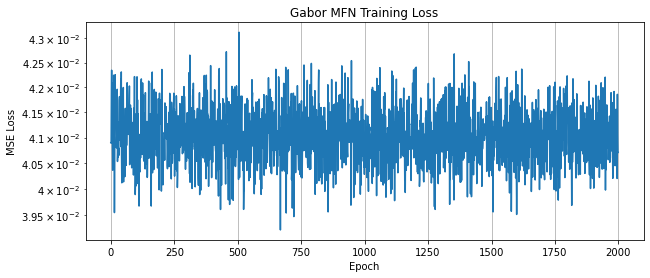

=== Gabor MFN Evaluation (Denormalized)===
MSE: 0.000538
PSNR: 14.10 dB
Saved waveform plot to outputs_piano/gabor_waveform.png



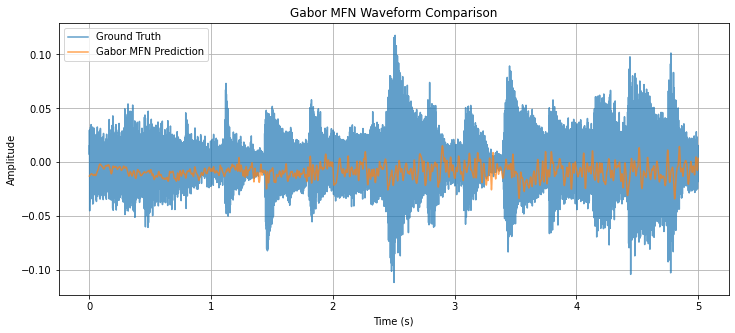

Ground Truth Audio (5.00 seconds):


Gabor MFN Predicted Audio (5.00 seconds):


Saved predicted audio to outputs_piano/gabor_audio.wav

Final Gabor MFN metrics: MSE=0.000538, PSNR=14.10dB



In [11]:
# CHOOSE 0 1 2
choice = 2
audio_file = audio_paths[choice]
output_path = output_paths[choice]

print("\n" + "="*50)
print(f"\nTraining Gabor MFN model on {os.path.basename(audio_file)}")
print("="*50)

# Create dataset
dataset = AudioSignalDataset(
    audio_file,
    normalize_time=True,
    normalize_amplitude=True
)

# Configure Gabor MFN model
hidden_size = 64
num_layers = 4
omega_0 = 30

gabor_mfn_model = get_gabor_mfn_model(
    hidden_size=hidden_size,
    num_layers=num_layers,
    omega_0=omega_0
)

# Print model details
num_params = sum(p.numel() for p in gabor_mfn_model.parameters())
print(f"Gabor MFN model parameters: {num_params:,}")

# Training hyperparameters
num_epochs = 2000
batch_size = 2**14
learning_rate = 4e-7

# Train Gabor MFN model
start_time = time.time()

gabor_mfn_model, gabor_mfn_losses = train_inr_model(
    gabor_mfn_model, 
    dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    lr=learning_rate, 
    device=device
)

training_time = time.time() - start_time
print(f"Gabor MFN training completed in {training_time:.2f} seconds")

# Plot Gabor MFN training curve
fig = plt.figure(figsize=(10, 4))
plt.plot(gabor_mfn_losses)
plt.title("Gabor MFN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.grid(True)
plt.show()
fig.savefig(f"{output_path}/gabor_loss.png", dpi=300, bbox_inches='tight')

# Evaluate Gabor MFN model
predictions, ground_truth, mse, psnr = evaluate_and_visualize(
    gabor_mfn_model, 
    dataset, 
    "Gabor MFN",
    save_audio=f"{output_path}/gabor_audio.wav",
    save_plot=f"{output_path}/gabor_waveform.png"
)

print(f"\nFinal Gabor MFN metrics: MSE={mse:.6f}, PSNR={psnr:.2f}dB\n")

In [12]:
# CHOOSE 0 1 2
audio_file_idx = 2
audio_file = audio_paths[audio_file_idx]
print("\n" + "="*50)
print(f"\nTraining PyTorch DQNN on {os.path.basename(audio_file)}")
print("="*50)

# Create dataset for the DQNN
dqnn_dataset = DQNNAudioDataset(
    audio_file,
    normalize_time=True,      # Normalize time to [0,1]
    normalize_amplitude=True  # Normalize amplitude for better convergence
)

# Configure DQNN model
# Simplest architecture: [1, 2, 2, 1]
# - 1 qubit for input (time)
# - 2 qubits in two hidden layers
# - 1 qubit for output (amplitude)
dqnn_model = get_dqnn_model(
    input_qubits=1,
    hidden_qubits=[2, 2],
    output_qubits=1,
    device=None  # Auto-select device
)

# Training hyperparameters
num_epochs = 200  # Using fewer epochs for demonstration
batch_size = 128
learning_rate = 0.01

# Train DQNN model
start_time = time.time()

dqnn_model, dqnn_losses = train_dqnn_model(
    dqnn_model,
    dqnn_dataset,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate
)

training_time = time.time() - start_time
print(f"PyTorch DQNN training completed in {training_time:.2f} seconds")

# Plot DQNN training curve
plot_training_curve(
    dqnn_losses, 
    "PyTorch DQNN", 
    save_path="outputs/pytorch_dqnn/loss.png"
)

# Evaluate DQNN model
print("\nEvaluating PyTorch DQNN model...")
predictions, ground_truth, mse, psnr = evaluate_and_visualize_dqnn(
    dqnn_model,
    dqnn_dataset,
    "PyTorch DQNN",
    save_audio="outputs/pytorch_dqnn/audio.wav",
    save_plot="outputs/pytorch_dqnn/waveform.png"
)

print(f"\nFinal PyTorch DQNN metrics: MSE={mse:.6f}, PSNR={psnr:.2f}dB")



Training PyTorch DQNN on piano_by_bach.wav
Audio loaded: 220500 samples, 5.00 seconds at 44100Hz
Original amplitude range: (-0.1114, 0.1176)
Normalized amplitude range: (-1.0000, 1.0000)
Normalized time range: [0, 1] (220500 samples)
DQNN architecture: [1, 2, 2, 1]
DQNN parameters: 224
DQNN running on: cuda
Starting training for 200 epochs on cuda...


  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x4 and 8x8)